# Import library

In [326]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from collections import defaultdict
from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator

**For improvement**

potentially I need to create a function that can 1)load different excel file tab and then create separate function for threshold detection, mean_Omax and average gain with different input arguments

# Import excel spreadsheet

In [327]:
# Path to your Excel file
data_excel_path = 'I-O_2wMMZ_GBZ_2412_2502'+'.xlsx'

# Print sheet names
data_excel = pd.ExcelFile(data_excel_path)
sheet_names = data_excel.sheet_names

# Read all sheets into a dictionary
df_dict = {name: pd.read_excel(data_excel, sheet_name=name, header=None) for name in sheet_names}

# Input threshold (1st input current that evoked any spikes)

In [328]:
# Creates an empty dict for storing input threshold at the beginning of execution
input_threshold_dict = defaultdict(list) # Ensures old values are removed

# Processing sheet by sheet in the excel file - one sheet is one experimental group
for df_name, df in df_dict.items():
    
    # Label the experimental group
    print(f"{df_name}")
    
    # Column 1 of the dataframe is a series containing different input stimulation intensity
    stimulation_current_series = df.iloc[:,0]
    
    # Take all the rows and rest of the column as output
    output_df = df.iloc[:, 1:]
    
    #print(type(stimulation_current_series))
    #print(type(output_df))
    
    # Process column by column in the dataframe - one column is one cell
    for cell,cell_output in output_df.items():

        #print("This cell is number" + str(cell))
        #print(cell_output)
        
        # Input threshold detection
        cell_output_list = list(cell_output) # Converting cell output from a series to a list

        try:
            # Store the 1st index of output > 0
            # !Warning!: cell_output_list must be sorted in an ascending order of input
            input_threshold_index = next(x[0] for x in enumerate(cell_output_list) if x[1] > 0)
            
            # Extract input threshold value
            input_threshold_value = stimulation_current_series.iloc[input_threshold_index]
            
        except StopIteration:
            input_threshold_value = None  # If no threshold found, store None

        # Store values in dictionary, ensuring it's a list
        input_threshold_dict[df_name].append(input_threshold_value)
        #input_threshold_dict.setdefault(df_name, []).append(input_threshold_value)

    print("\n")  # Newline for better output formatting

# Convert defaultdict back to a normal dictionary if needed
#input_threshold_dict = dict(input_threshold_dict)

2w_Baseline


PBS_Baseline


2w_GBZ


PBS_GBZ




# Calculate Rmax (~80%)

In [329]:
# Creates an empty dict for storing input threshold at the beginning of execution
mean_Omax_dict = defaultdict(list) # Ensures old values are removed

# Processing sheet by sheet in the excel file - one sheet is one experimental group
for df_name, df in df_dict.items():
    
    # Label the experimental group
    print(f"{df_name}")
    
    # Column 1 of the dataframe is a series containing different input stimulation intensity
    stimulation_current_series = df.iloc[:,0]
    
    # Take all the rows and rest of the column as output
    output_df = df.iloc[:, 1:]
    
    #print(type(stimulation_current_series))
    #print(type(output_df))
    
    # Process column by column in the dataframe - one column is one cell
    for cell,cell_output in output_df.items():
        
        cell_output_max = cell_output.max()
        normalised_cell_output = cell_output / cell_output_max
        
        # Extract values from 'output' where the corresponding value in 'normalized_output' is greater than 0.8

        threshold = 0.8 # HARDCODED: Adjust as you like

        mask = normalised_cell_output > threshold
        
        Omax_output = cell_output[mask]
        mean_Omax_output = Omax_output.mean()
        

        # Display the filtered output
        #print(Omax_output)
        #print(mean_Omax_output)
        
        # Store values in dictionary, ensuring it's a list
        mean_Omax_dict[df_name].append(mean_Omax_output)
        

    print("\n")  # Newline for better output formatting

# Convert defaultdict back to a normal dictionary if needed
#input_threshold_dict = dict(input_threshold_dict)

2w_Baseline


PBS_Baseline


2w_GBZ


PBS_GBZ




In [330]:
mean_Omax_dict["2w_Baseline"]

[137.5, 245.0, 80.16666666666667, 183.0, 318.75, 138.125]

In [256]:
mean_Omax_dict["PBS_Baseline"]

[170.0, 131.0, 116.75, 138.66666666666666, 232.25, 321.75, 194.5]

In [331]:
mean_Omax_dict["2w_GBZ"]

[178.5, 194.5, 178.5, 263.0, 67.0, 658.75, 148.375, 181.16666666666666, 98.0]

In [332]:
mean_Omax_dict["PBS_GBZ"]

[480.0, 178.0, 132.0, 161.5, 172.5]

# Calculate average gain

Note the input has not been converted to uA yet - right now these number(i.e. input intensity) are what is shown on the stimulator

Don't know why it is less fitted than MATLAB.pchip()

## PchipInterpolator - (switch to MATLAB for now)

/var/folders/rf/68fryfnn0xsbf4jsd6m_22br0000gn/T/ipykernel_80146/3277868774.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 6))


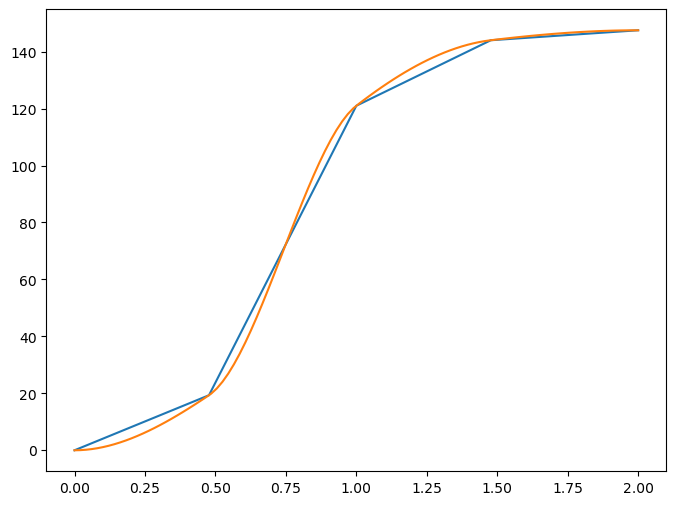

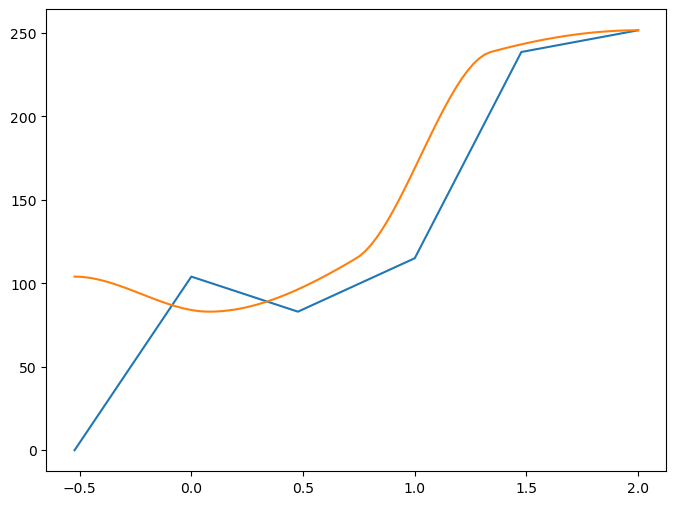

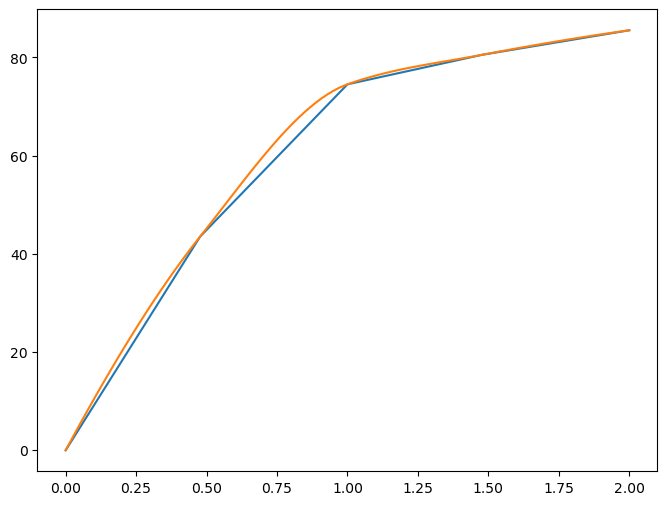

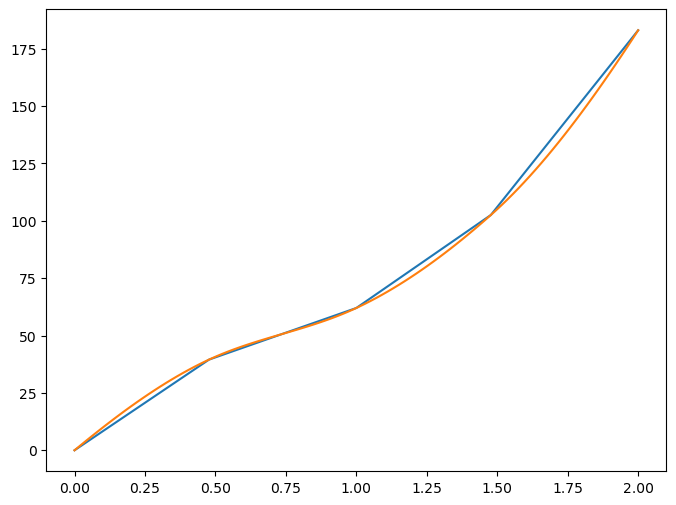

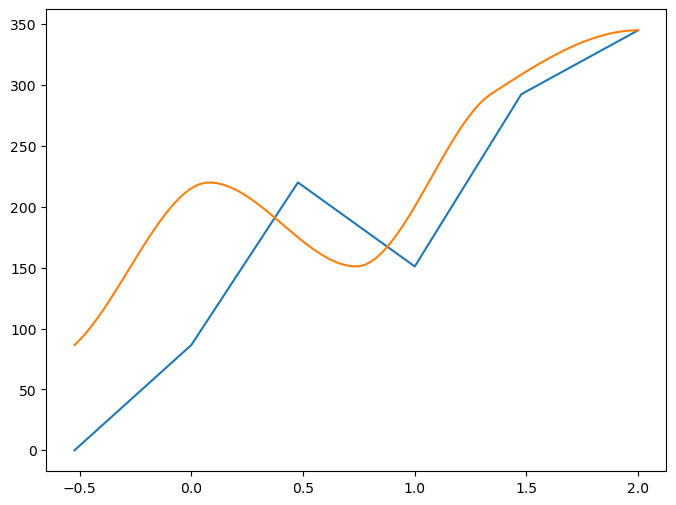

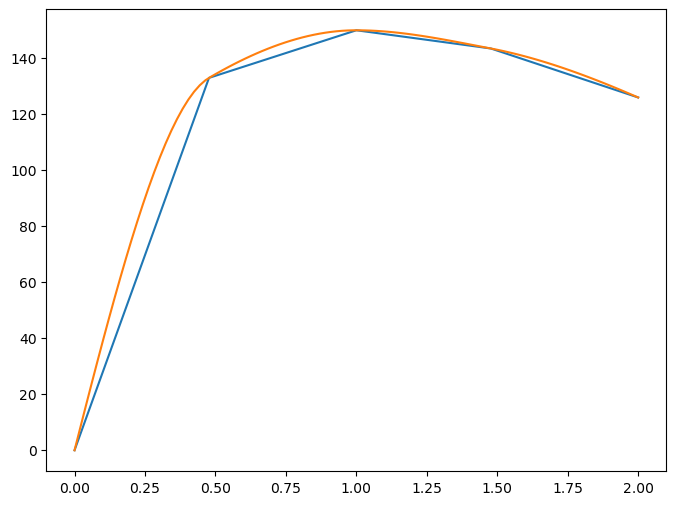

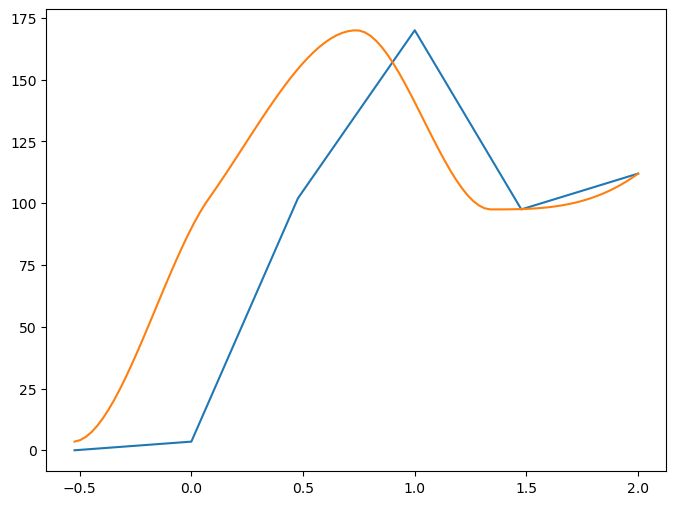

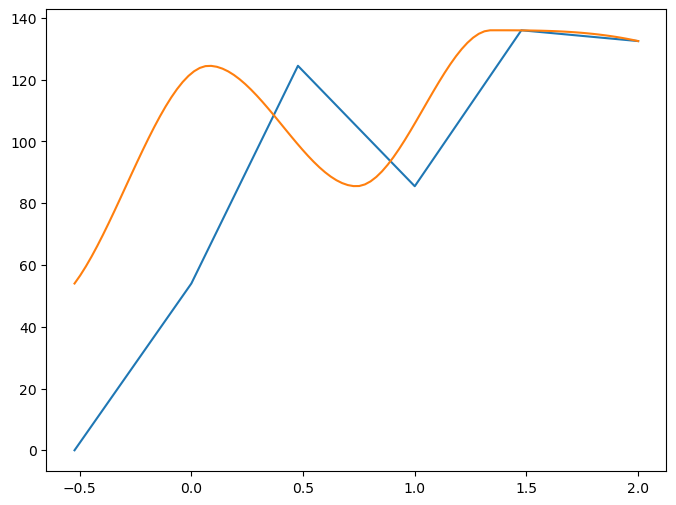

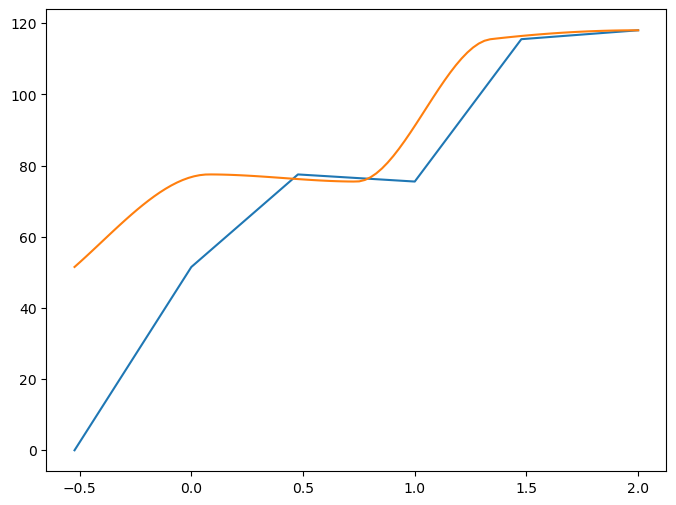

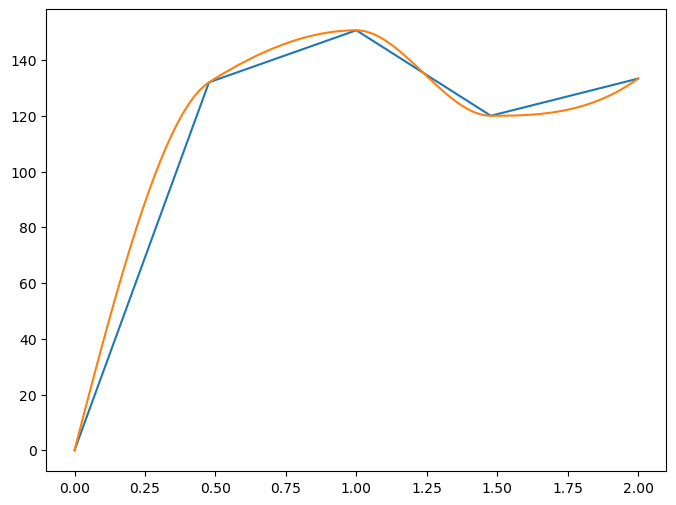

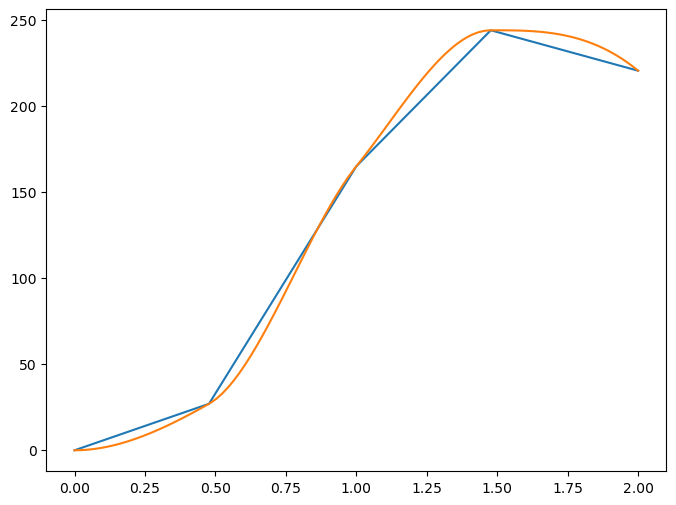

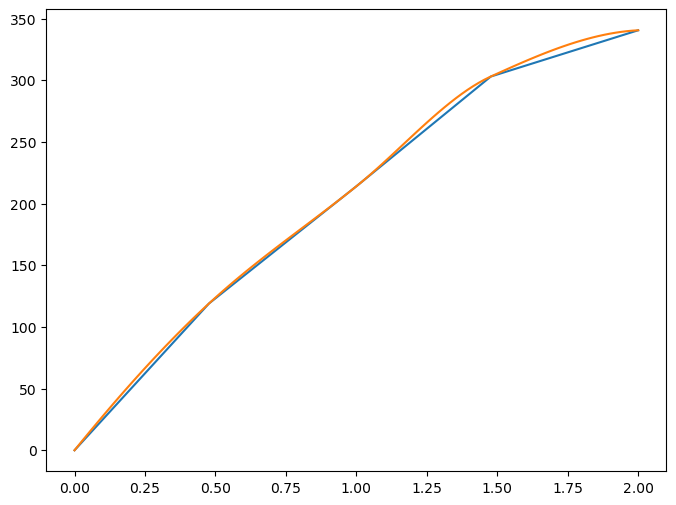

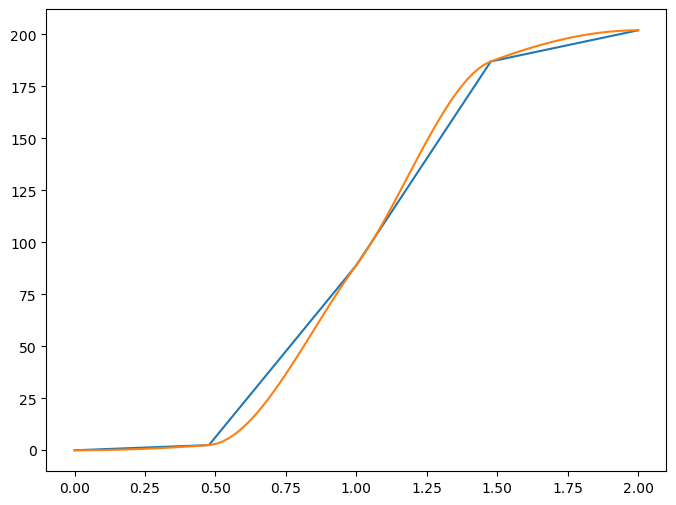

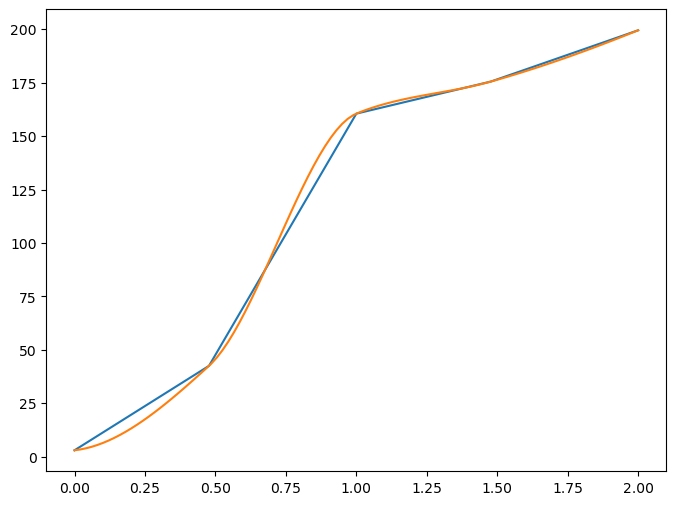

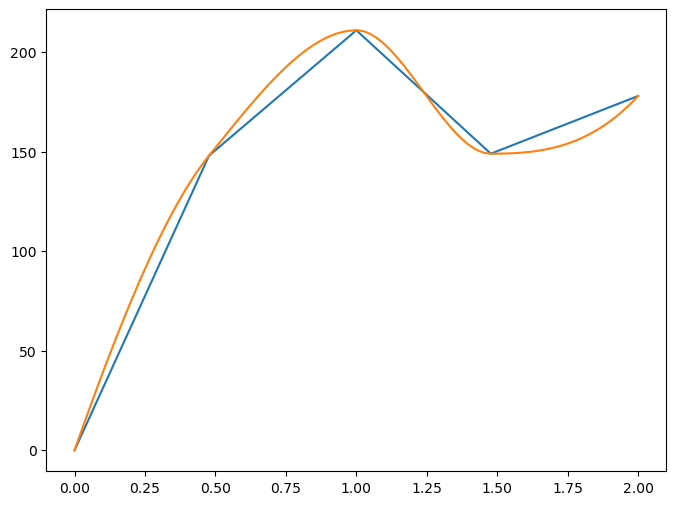

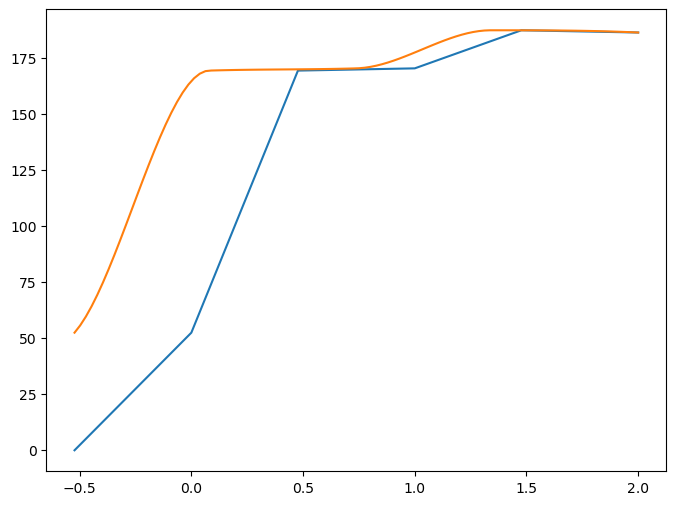

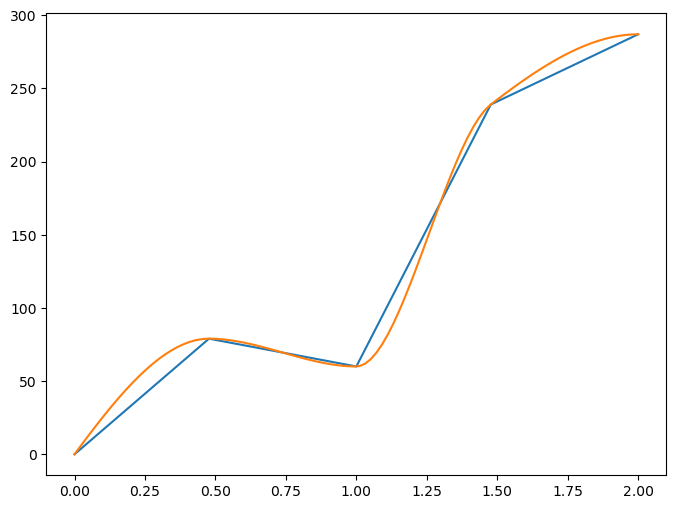

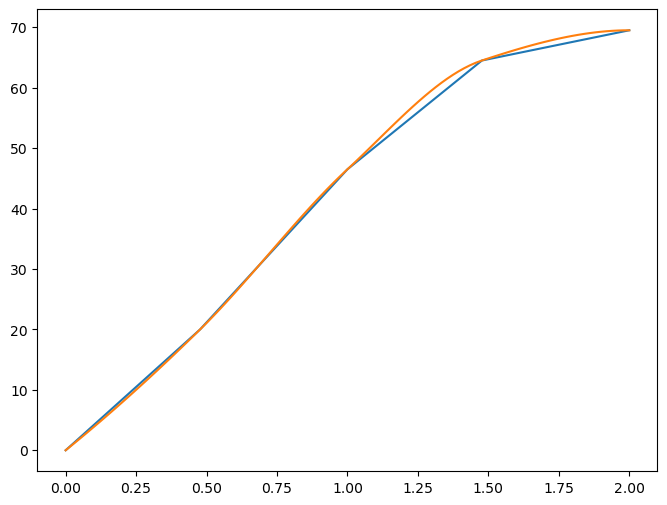

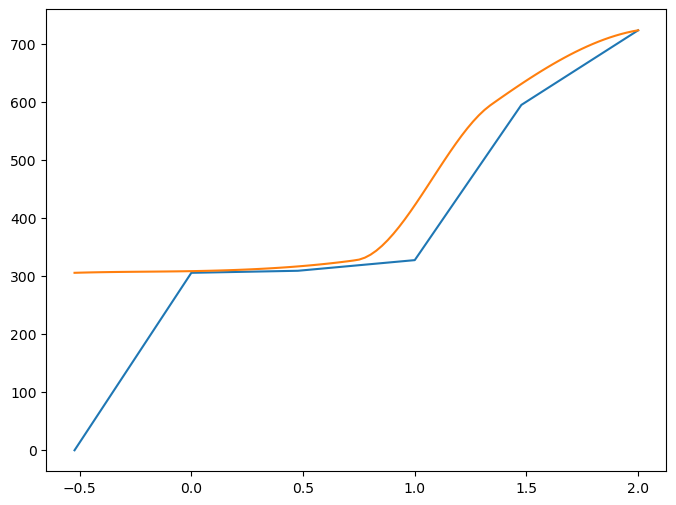

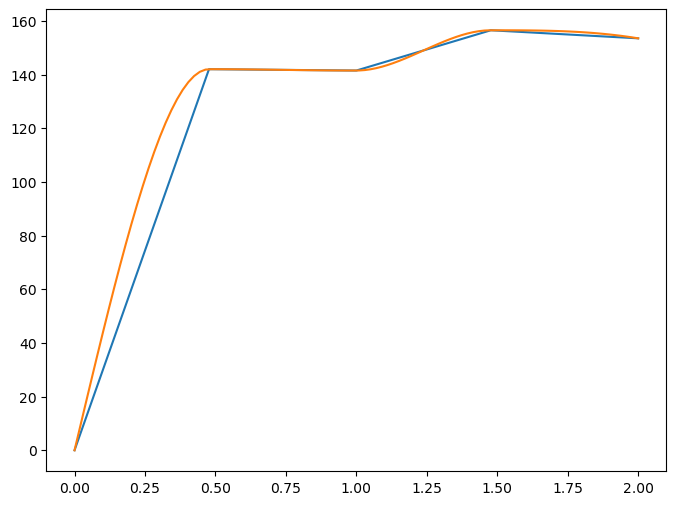

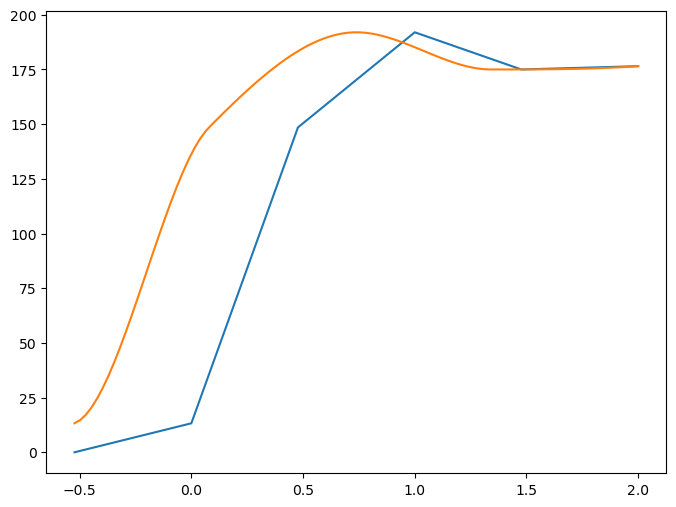

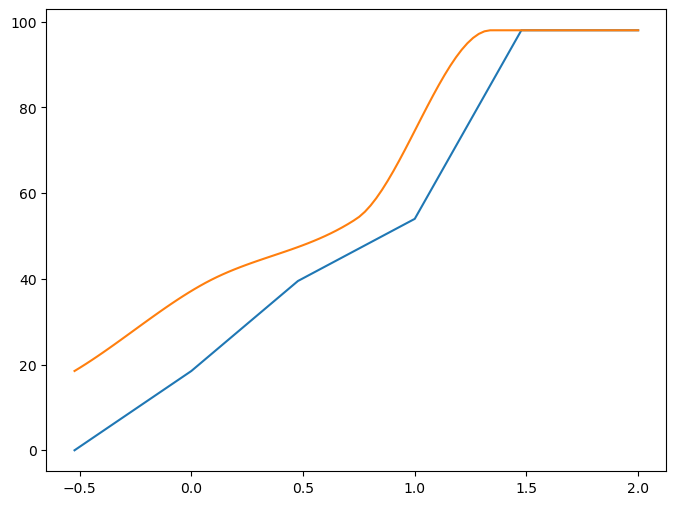

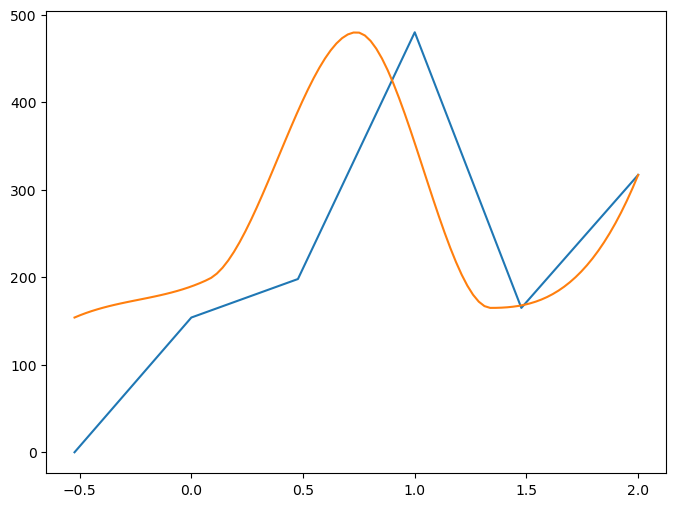

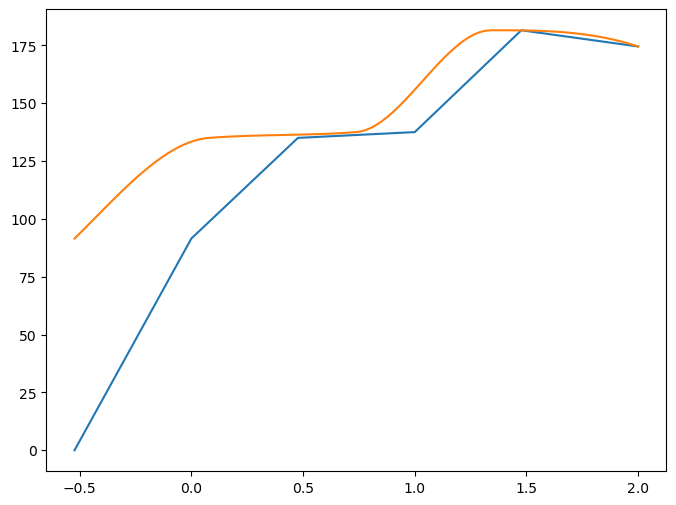

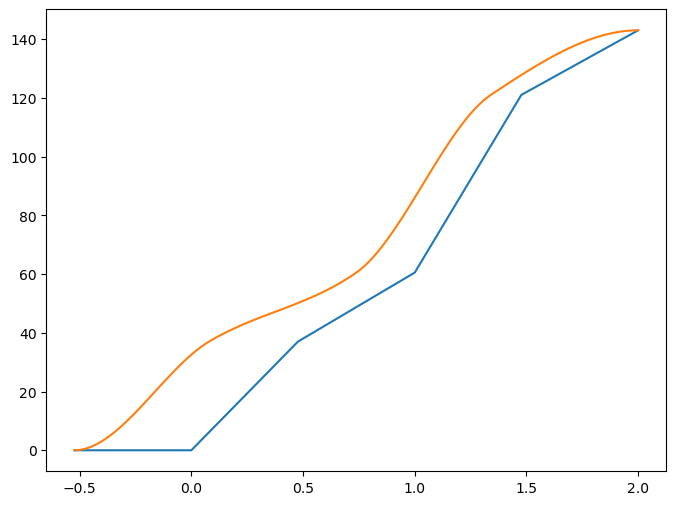

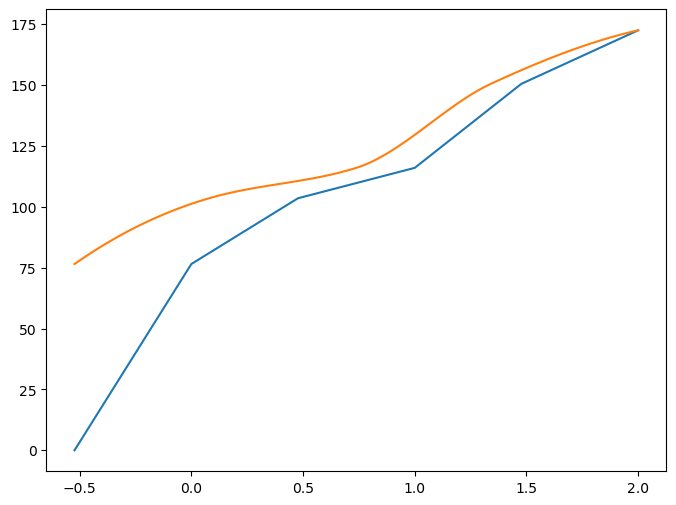

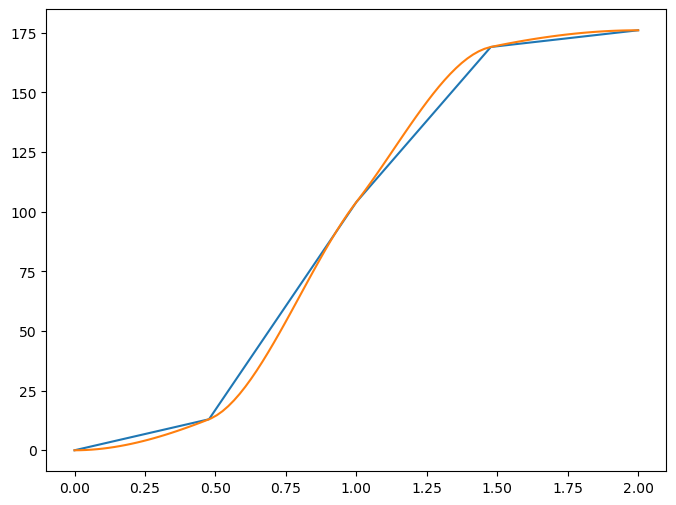

In [324]:
# Processing sheet by sheet in the excel file - one sheet is one experimental group
for df_name, df in df_dict.items():
    
    
    # Column 1 of the dataframe is a series containing different input stimulation intensity
    stimulation_current_series = df.iloc[:,0]
    
    # Log10 transform input
    log_stimulation_current_series = np.log10(stimulation_current_series)
    
    
    # Take all the rows and rest of the column as output
    output_df = df.iloc[:, 1:]
    
    # Create a new figure for each sheet/df (new experimental group)
    #plt.figure(figsize=(8, 6))  

    
    # Process column by column in the dataframe - one column is one cell
    for cell,cell_output in output_df.items():
        
        # Remove NaN and inf values in the table
        Non_NaNorinf = np.isfinite(cell_output) & np.isfinite(log_stimulation_current_series)
        
        filtered_output = cell_output[Non_NaNorinf]
        filtered_input  = log_stimulation_current_series[Non_NaNorinf]
        
        if len(filtered_input) & len(filtered_output) > 2:
        
            # Fitting a cubic spline
            pchip = PchipInterpolator(filtered_input,filtered_output)
            
            # Generate 100 evenly spaced datapoint between min and max of input
            x_pchip = np.linspace(min(filtered_input),max(filtered_input),100)
            y_pchip = pchip(x_new)  # Base on the CubicSpline function, compute y-values from x
            
        
            # Create a new figure for each sheet/df (new experimental group)
            plt.figure(figsize=(8, 6))
            plt.plot(filtered_input,filtered_output)
            plt.plot(x_pchip,y_pchip)
            
            
        
        else:
        
            print(f"{cell} has less than two input or output")
        
        
        
        #print(len(filtered_output))
        
        
        #print("NaN values in y:", np.isnan(cell_output_rounded).any())  # Check for NaN
        #print("Infinite values in y:", np.isinf(cell_output_rounded).any())  # Check for inf

In [287]:
from scipy.interpolate import CubicSpline

# Sample data (known points)
x = np.array([0, 1, 2, 3, 4, 5])
y = np.array([0, 2, 1, 3, 7, 5])

# Fit cubic spline
cs = CubicSpline(x, y)

print(cs)

# Generate new interpolated points
#x_new = np.linspace(min(x), max(x), 100)
#y_new = cs(x_new)  # Compute interpolated values

# Plot results
#plt.scatter(x, y, color='red', label="Original Data")  # Data points
#plt.plot(x_new, y_new, label="Cubic Spline", linestyle="--")  # Spline curve
#plt.legend()
#plt.show()


### Normalise output by their own max values

In [5]:
# Apply lambda function - normalise values to their max values in their column - to output

normalised_output = output.apply(lambda x: x / x.max(), axis=0) # z.apply(func,axis=0);Apply func on every columns (axis = 0) of the variable 'z'
                                                                # func = lamda x: x / x.max(); lamda argu: expression
                                                                # lamda is an an anonymous function that takes arguement x and computes x/x.max()
# E.g
# output.apply(lamda x:, axis=0) -> x=[0, 0, 0, 4.667, 10.333, 30]
#lamda x: x/x.max() -> 0/30, 4.667/30 etc...
        
# Display the normalized output
print(normalised_output)

         1         2         3         4         5        6         7   \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000  0.005540   
3  0.000000  0.000000  0.000000  0.673077  0.577143  0.00000  0.520776   
4  0.064286  0.182609  0.278884  0.923077  0.891429  0.44898  0.886427   
5  1.000000  1.000000  1.000000  1.000000  1.000000  1.00000  1.000000   
6       NaN       NaN       NaN       NaN       NaN      NaN       NaN   
7       NaN       NaN       NaN       NaN       NaN      NaN       NaN   

         8         9         10        11        12        13        14  \
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1       NaN       NaN       NaN       NaN       NaN  0.000000  0.000000   
2  0.000000  0.000000       NaN       NaN       NaN  0.129771  0.090909   
3  0.091483  0.119048       NaN  

### Extract output values (Rmax >80%)

In [6]:
# Extract values from 'output' where the corresponding value in 'normalized_output' is greater than 0.8

threshold = 0.8 # HARDCODED: Adjust as you like

mask = normalised_output > threshold
Rmax_output = output[mask]

# Display the filtered output
print(Rmax_output)

          1          2          3          4          5     6           7   \
0        NaN        NaN        NaN        NaN        NaN   NaN         NaN   
1        NaN        NaN        NaN        NaN        NaN   NaN         NaN   
2        NaN        NaN        NaN        NaN        NaN   NaN         NaN   
3        NaN        NaN        NaN        NaN        NaN   NaN         NaN   
4        NaN        NaN        NaN  64.000000  52.000000   NaN  106.666667   
5  46.666667  38.333333  83.666667  69.333333  58.333333  73.5  120.333333   
6        NaN        NaN        NaN        NaN        NaN   NaN         NaN   
7        NaN        NaN        NaN        NaN        NaN   NaN         NaN   

      8      9         10          11         12         13    14         15  \
0    NaN    NaN       NaN         NaN        NaN        NaN   NaN        NaN   
1    NaN    NaN       NaN         NaN        NaN        NaN   NaN        NaN   
2    NaN    NaN       NaN         NaN        NaN        N

### Calculate single-cell Rmax mean

In [7]:
# Calculate the average of all columns in output. This operation converts dataframe to series
Rmax_average = Rmax_output.mean(axis=0) #axis = 0 specifies column-wise operation. axis = 1 is for row-wise.

#print ('Average of all columns in output:')
print (Rmax_average)

1      46.666667
2      38.333333
3      83.666667
4      66.666667
5      55.166667
6      73.500000
7     113.500000
8     150.250000
9     209.250000
10      8.500000
11    107.666667
12     32.333333
13     43.666667
14     33.000000
15     33.333333
16    108.250000
dtype: float64


### Stack Rmax values together

In [8]:
#Remove NA values from each column
cleaned_df = Rmax_output.stack().reset_index(drop=True) #.stack():stack columns of Rmax_output into a single column (series)
                                                        #Performing such function remove NA values conviniently

# Step 2: Convert the Series to a DataFrame with a single column for clarity
Rmax_df = pd.DataFrame(cleaned_df, columns=['Value'])

# Display the resulting DataFrame
print(Rmax_df)

         Value
0    64.000000
1    52.000000
2   106.666667
3    46.666667
4    38.333333
5    83.666667
6    69.333333
7    58.333333
8    73.500000
9   120.333333
10  142.000000
11  107.666667
12   33.000000
13   36.333333
14  101.250000
15  158.500000
16  210.000000
17    8.666667
18   43.666667
19   32.333333
20  111.750000
21  208.500000
22    8.333333
23   32.333333
24   31.333333
25  111.750000


### Confirm Rmax values

In [9]:
# stack Rmax_output into a series & reset their index
Rmax_output_s = Rmax_output.stack().reset_index(drop=True)

# Check each element to see if it's an integer and count the number of integers
Rmax_count = Rmax_output_s.apply(lambda x: isinstance(x, (float))).sum()

# Display the count of integers
print(f"Number of integers in Rmax_output: {Rmax_count}")

Number of integers in Rmax_output: 26


### Extract the largest output value - single cell

In [33]:
# Get the max, non-NaN values for each column
max_output_values = np.nanmax(output, axis=0)

# Convert max_output_values from array to dataframe for stacking
max_output_values_df = pd.DataFrame(max_output_values)

# Stack maximun values into a single column
max_output_values_df_stack = max_output_values_df.stack().reset_index(drop=True)

# Display the maximum values for each column
print(max_output_values_df_stack)

0      46.666667
1      38.333333
2      83.666667
3      69.333333
4      58.333333
5      73.500000
6     120.333333
7     158.500000
8     210.000000
9       8.666667
10    107.666667
11     32.333333
12     43.666667
13     33.000000
14     36.333333
15    111.750000
dtype: float64


## Calculation ∆output (s)

In [11]:
# Calculate the differences (delta) for each column
output_delta = output.diff()

# Include the first row by combining it with the calculated differences
output_delta.iloc[0] = output.iloc[0]  # Retain the first row of output_delta as output


# Print the result
print(output_delta)

          1          2          3          4          5     6          7   \
0   0.000000   0.000000   0.000000   0.000000   0.000000   0.0   0.000000   
1   0.000000   0.000000   0.000000   0.000000   0.000000   0.0   0.000000   
2   0.000000   0.000000   0.000000   0.000000   0.000000   0.0   0.666667   
3   0.000000   0.000000   0.000000  46.666667  33.666667   0.0  62.000000   
4   3.000000   7.000000  23.333333  17.333333  18.333333  33.0  44.000000   
5  43.666667  31.333333  60.333333   5.333333   6.333333  40.5  13.666667   
6        NaN        NaN        NaN        NaN        NaN   NaN        NaN   
7        NaN        NaN        NaN        NaN        NaN   NaN        NaN   

      8     9         10         11         12         13         14  \
0    NaN   NaN       NaN        NaN        NaN        NaN        NaN   
1    NaN   NaN       NaN        NaN        NaN        NaN        NaN   
2    NaN   NaN       NaN        NaN        NaN   5.666667   3.000000   
3   14.5  25.0    

## Calculate averaged ∆output (s)

In [12]:
# Calculate the average of all columns in output. This operation converts dataframe to series
output_average = output.mean(axis=1) #axis = 1 specifies column-wise operation. axis = 0 is for row-wise.

print ('Average of all columns in output:')
print (output_average)
type(output_average)

#Convert output_average from series to dataframe for plotting later
output_average_df = output_average.to_frame(name='Average Output')

# Remove the first row by slicing
#output_average_df = output_average_df.iloc[1:]

# Verify the change
print(output_average_df)

Average of all columns in output:
0     0.000000
1     0.000000
2     0.717949
3    14.866667
4    40.328125
5    70.453125
6    75.064815
7    84.440476
dtype: float64
   Average Output
0        0.000000
1        0.000000
2        0.717949
3       14.866667
4       40.328125
5       70.453125
6       75.064815
7       84.440476


In [13]:
# Calculate the differences (delta) for each column from B to Q
output_average_delta = output_average.diff() #remove the NA value of the 1st row

# Print the result
print(output_average_delta)

0          NaN
1     0.000000
2     0.717949
3    14.148718
4    25.461458
5    30.125000
6     4.611690
7     9.375661
dtype: float64


## Create input

In [14]:
# Print out all the output columns and exclude the 1st column which contains input current injection
Input = df.iloc[:,0]

print (Input)

0       0.3
1       1.0
2       3.0
3      10.0
4      30.0
5     100.0
6     300.0
7    1000.0
Name: 0, dtype: float64


## Log transform input (Log_input)

In [15]:
# Applying log transformation to the Input data
log_Input = np.log10(Input)

# Print the transformed data
print(log_Input)

0   -0.522879
1    0.000000
2    0.477121
3    1.000000
4    1.477121
5    2.000000
6    2.477121
7    3.000000
Name: 0, dtype: float64


## Calculate ∆Log current (Log uA)

In [16]:
# Calculate the differences (delta) for current injection
log_Input_delta = log_Input.diff().dropna()

# Print the result
print(log_Input_delta)

1    0.522879
2    0.477121
3    0.522879
4    0.477121
5    0.522879
6    0.477121
7    0.522879
Name: 0, dtype: float64


In [17]:
output_delta

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.666667,NaN,NaN,NaN,NaN,NaN,5.666667,3.000000,NaN,NaN
3,0.000000,0.000000,0.000000,46.666667,33.666667,0.0,62.000000,14.5,25.0,NaN,NaN,NaN,9.666667,3.666667,9.000000,4.50
4,3.000000,7.000000,23.333333,17.333333,18.333333,33.0,44.000000,11.0,93.5,NaN,60.666667,19.000000,5.000000,9.000000,4.333333,73.75
5,43.666667,31.333333,60.333333,5.333333,6.333333,40.5,13.666667,116.5,41.0,5.666667,47.000000,-5.000000,12.333333,17.333333,23.000000,23.00
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.5,50.5,3.000000,-46.000000,3.666667,11.000000,-6.666667,-4.000000,10.50
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-39.0,-1.5,-0.333333,17.666667,9.666667,NaN,NaN,-1.000000,0.00


In [35]:
6.3333/0.522879

12.112362515993185

## Calculate gain (∆s/∆log_uA) - single cell

In [19]:
# Divide each column of output_delta by input_delta
gain = output_delta.div(log_Input_delta, axis=0)

print(gain)
type(gain)

          1          2           3          4          5          6   \
0        NaN        NaN         NaN        NaN        NaN        NaN   
1   0.000000   0.000000    0.000000   0.000000   0.000000   0.000000   
2   0.000000   0.000000    0.000000   0.000000   0.000000   0.000000   
3   0.000000   0.000000    0.000000  89.249500  64.387139   0.000000   
4   6.287710  14.671323   48.904410  36.328990  38.424893  69.164808   
5  83.512032  59.924664  115.386854  10.199943  12.112432  77.455816   
6        NaN        NaN         NaN        NaN        NaN        NaN   
7        NaN        NaN         NaN        NaN        NaN        NaN   

           7           8           9          10          11         12  \
0         NaN         NaN         NaN        NaN         NaN        NaN   
1    0.000000         NaN         NaN        NaN         NaN        NaN   
2    1.397269         NaN         NaN        NaN         NaN        NaN   
3  118.574336   27.731095   47.812232        NaN   

pandas.core.frame.DataFrame

### Stack gain values

In [20]:
# Stack the gain DataFrame into a single column, removing NaN values
gain_stacked = gain.stack(dropna=True).reset_index(drop=True)

# Display the resulting single-column DataFrame
print("single cell gain (stacked):")
print(gain_stacked)

single cell gain (stacked):
0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
        ...    
71    -0.637496
72    33.787311
73    18.487396
74    -1.912489
75     0.000000
Length: 76, dtype: float64


In [21]:
output_average_delta

0          NaN
1     0.000000
2     0.717949
3    14.148718
4    25.461458
5    30.125000
6     4.611690
7     9.375661
dtype: float64

In [22]:
log_Input_delta

1    0.522879
2    0.477121
3    0.522879
4    0.477121
5    0.522879
6    0.477121
7    0.522879
Name: 0, dtype: float64

## Calculate averaged gain (∆s/∆uA)

In [23]:
# Divide each column of output_delta by input_delta
gain_average = output_average_delta.div(log_Input_delta, axis=0).dropna() #This operation convert from dataframe into series

# Print the result
print("average gain:")
print(gain_average)
type(gain_average)

#Convert gain_average from series to dataframe
gain_average_df = gain_average.to_frame(name='Average Gain')
type(gain_average_df)

average gain:
1     0.000000
2     1.504751
3    27.059272
4    53.364754
5    57.613740
6     9.665656
7    17.930852
dtype: float64


pandas.core.frame.DataFrame

In [24]:
30.125/0.522879

57.61371177652956

## Plotting gain against output (single cell)

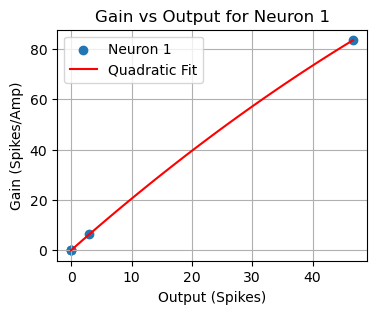

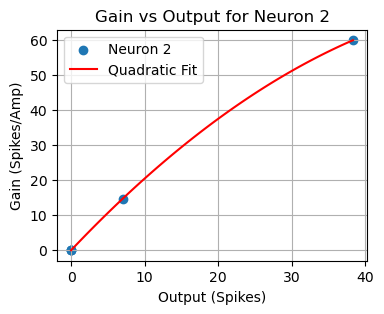

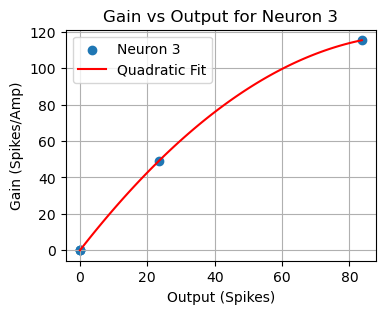

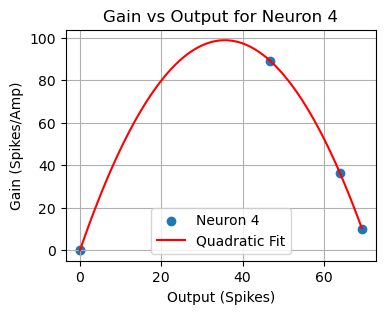

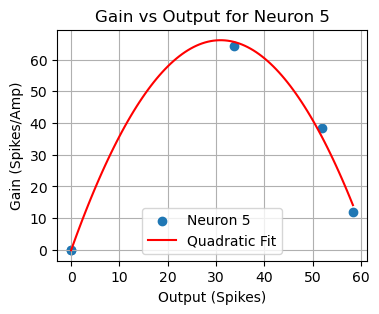

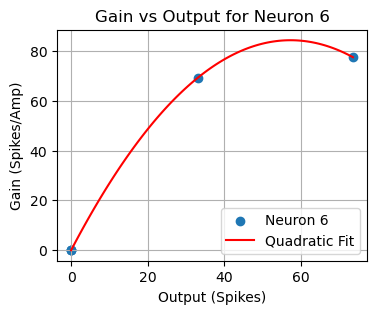

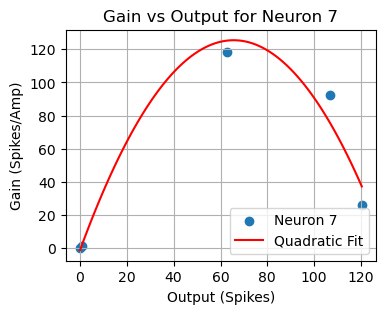

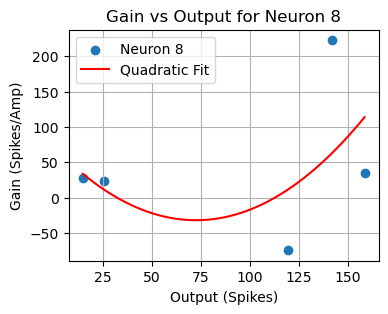

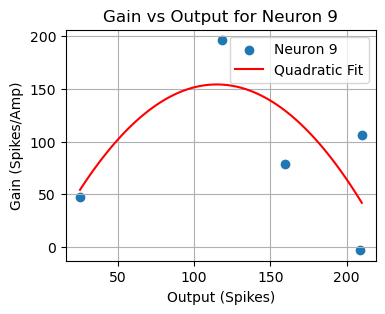

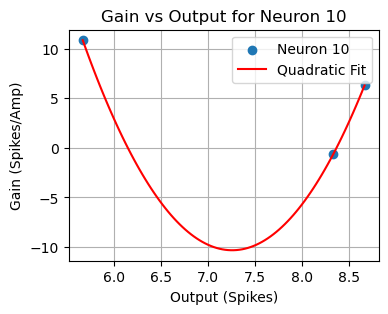

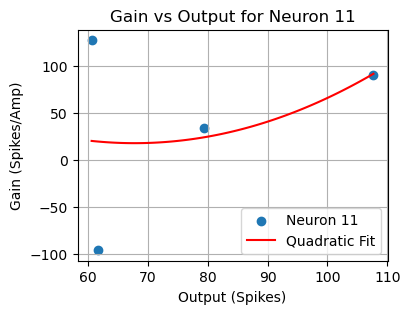

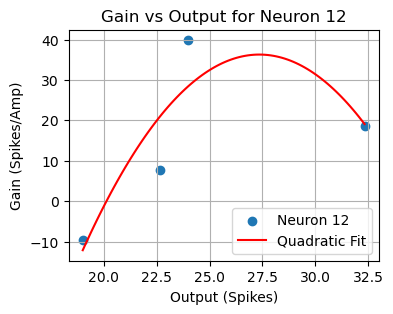

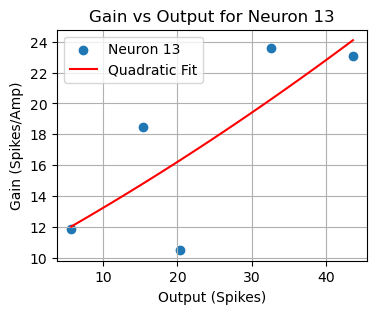

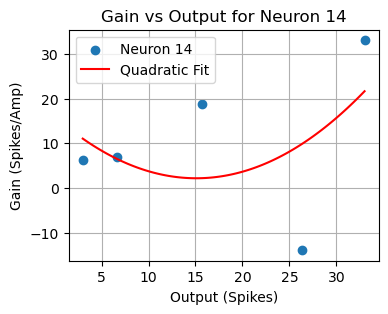

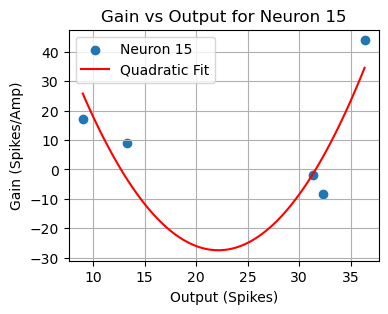

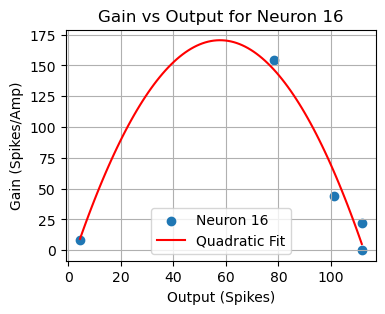

In [25]:
for column in gain.columns:
    plt.figure(figsize=(4, 3))
    plt.scatter(output[column], gain[column], label=f'Neuron {column}') # Plotting gain vs output

    # Remove NaN values for fitting
    valid_idx = ~output[column].isna() & ~gain[column].isna() # Create an invert (~) boolean array to identiy Non-NaN values in both output and gain
    x = output[column][valid_idx] #Sort out output values that is Non-NaN in both output and gain.
    y = gain[column][valid_idx] #Same but for gain

    # Fit a second-order polynomial
    coefficients = np.polyfit(x, y, 2) #Creates an array of coefficinet from the x & y values and use it for interpolation

    # Create a polynomial function from the coefficients
    poly_func = np.poly1d(coefficients)

    # Generate x values for plotting the polynomial
    x_values = np.linspace(x.min(), x.max(), 100) # Create 100 evenly spaced x values between the max & min values of x
    y_values = poly_func(x_values) # Based on the generated polynomial function from our actual data, compute the y-values of those 100 x values.

    # Plot the polynomial fit
    plt.plot(x_values, y_values, '-', color='red', label='Quadratic Fit') # Plot the generated polynomial function

    # Adding labels and title
    plt.xlabel('Output (Spikes)')
    plt.ylabel('Gain (Spikes/Amp)')
    plt.title(f'Gain vs Output for Neuron {column}')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

## Plotting gain against output (population)

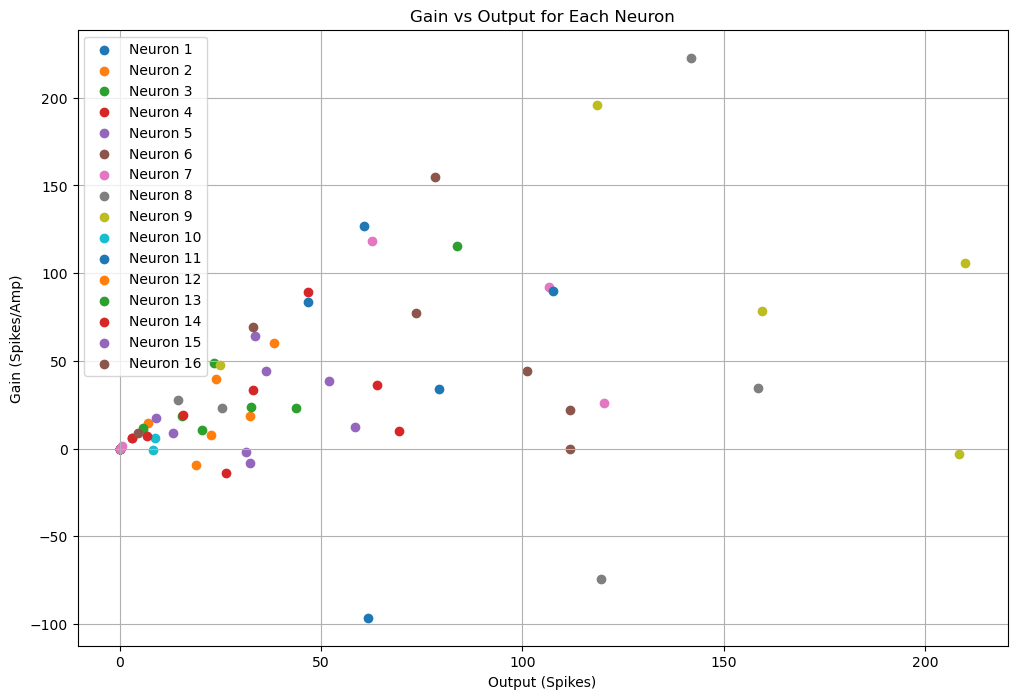

In [26]:
# Plot gain against output for each column (each cell)
plt.figure(figsize=(12, 8))

# Loop through each column to plot gain vs output
for column in gain.columns:
    plt.scatter(output[column], gain[column], label=f'Neuron {column}')

# Adding labels and title
plt.xlabel('Output (Spikes)')
plt.ylabel('Gain (Spikes/Amp)')
plt.title('Gain vs Output for Each Neuron')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## Plot averaged gain against averaged output

In [27]:
# Plot average gain against output for each column
plt.figure(figsize=(12, 8))


# Loop through each column to plot gain vs output
for column in gain_average_df.columns:
    plt.scatter(output_average_df[column], gain_average_df[column], label=f'Neuron {column}')

# Fit a second-order polynomial
coefficients = np.polyfit(output_average_df.values.flatten(), gain_average_df.values.flatten(), 2)

# Create a polynomial function from the coefficients
poly_func = np.poly1d(coefficients)

# Generate x values for plotting the polynomial
x_values = np.linspace(output_average_df.min().values[0], output_average_df.max().values[0], 100)
y_values = poly_func(x_values)

# Plot the polynomial fit
plt.plot(x_values, y_values, label='2nd Order Polynomial Fit', color='red')
    
# Adding labels and title
plt.xlabel('Output (Spikes)')
plt.ylabel('Gain (Spikes/Amp)')
plt.title('Gain vs Output for averaged I-O function')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

KeyError: 'Average Gain'

<Figure size 1200x800 with 0 Axes>

## Constraining the polynomial fit to 0,0

In [28]:
# Plot average gain against output for each column
plt.figure(figsize=(12, 8))


# Loop through each column to plot gain vs output
for column in gain_average_df.columns:
    plt.scatter(output_average_df[column], gain_average_df[column], label=f'Neuron {column}')

# Custom function for second-order polynomial passing through (0,0)
def poly_func(x, a, b):
    return a * x**2 + b * x

# Generate x and y data
x_data = output_average_df.values.flatten()
y_data = gain_average_df.values.flatten()

# Fit the data to the custom polynomial function
params, _ = curve_fit(poly_func, x_data, y_data)

# Generate x values for plotting the polynomial
x_values = np.linspace(min(x_data), max(x_data), 100)
y_values = poly_func(x_values, *params)

# Plot the polynomial fit
plt.plot(x_values, y_values, label='2nd Order Polynomial Fit', color='red')
    
# Adding labels and title
plt.xlabel('Output (Spikes)')
plt.ylabel('Gain (Spikes/Amp)')
plt.title('Gain vs Output for averaged I-O function')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

KeyError: 'Average Gain'

<Figure size 1200x800 with 0 Axes>

In [29]:
output_average_df

,Average Output
0,0.000000
1,0.000000
2,0.717949
3,14.866667
4,40.328125
5,70.453125
6,75.064815
7,84.440476


In [30]:
output_average_delta

0          NaN
1     0.000000
2     0.717949
3    14.148718
4    25.461458
5    30.125000
6     4.611690
7     9.375661
dtype: float64

In [31]:
log_Input_delta

1    0.522879
2    0.477121
3    0.522879
4    0.477121
5    0.522879
6    0.477121
7    0.522879
Name: 0, dtype: float64

In [32]:
gain_average_df

,Average Gain
1,0.000000
2,1.504751
3,27.059272
4,53.364754
5,57.613740
6,9.665656
7,17.930852


## Export to excel file

In [ ]:
# To save it to a specific directory

gain_stacked.to_excel('/Users/hyou/Documents/Haoming - MG Ephys (merge 20240612)/Data_Excel/4-5 weeks_MMZ/MMZ_gain_log input_subtracted.xlsx', index=False)